# Text Detection With EAST

In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
def text_detection_correction(**kwarg):
    #startX correction
    if kwarg['startX']<0:
        startX=0
    else:
        startX = kwarg['startX']
    #startY correction
    if kwarg['startY']<0:
        startY=0
    else:
        startY = kwarg['startY']
    #endX correction
    if kwarg['endX']>kwarg['W']:
        endX=0
    else:
        endX = kwarg['endX']
    #endY correction
    if kwarg['endY']>kwarg['H']:
        endY=0
    else:
        endY = kwarg['endY']
    return (startX, startY, endX, endY)

In [3]:
def text_detection(img_path, east_model, min_confidence, width, height):
    start = time.time()
    # load the input image and grab the image dimensions
    image = cv2.imread(img_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    east_model.setInput(blob)
    (scores, geometry) = east_model.forward(layerNames)
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            (startX, startY, endX, endY) = text_detection_correction(
                startX=startX, startY=startY, endX=endX, endY=endY, H=H, W=W
            )
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    orig_boxes = []
    for i,(startX, startY, endX, endY) in enumerate(boxes):
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        orig_boxes.append((startX, startY, endX, endY))
    end = time.time()
    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    return orig_boxes

In [4]:
img_path = 'dataset/test_ocr.png'
east_path = 'models/frozen_east_text_detection.pb'
min_confidence = 0.5
width = 320#need to be multiple of 32
height = 320#need to be multiple of 32

In [5]:
east_model = cv2.dnn.readNet(east_path)

[INFO] text detection took 0.267051 seconds


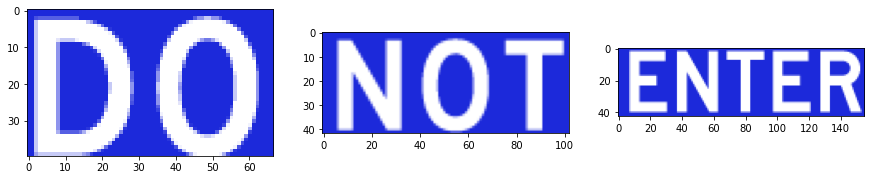

In [6]:
img_path = 'dataset/test_ocr.png'
img = cv2.imread(img_path)
text_detection_boxes = text_detection(img_path, east_model, min_confidence, width, height)
fig, axs = plt.subplots(nrows=1, ncols=len(text_detection_boxes), figsize=(15,10))
for i,(startX, startY, endX, endY) in enumerate(text_detection_boxes):
	axs[i].imshow(img[startY:endY, startX:endX,:])

# OCR Per-word With pytesseract

In [6]:
import pytesseract
from PIL import Image

In [7]:
#init with tesseract exe file location
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [8]:
def preprocess_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    return img

In [10]:
def ocr_with_tesseract(**kwarg):
    start = time.time()
    text_detection_boxes =  text_detection(kwarg['img_path'], kwarg['east_model'], kwarg['min_confidence'], kwarg['width'], kwarg['height'])
    img = cv2.imread(img_path)
    configuration = kwarg['tesseract_config']
    text=[]
    for (startX, startY, endX, endY) in (text_detection_boxes):
        try:
            text.append(pytesseract.image_to_string(img[startY:endY, startX:endX], config=configuration).split()[0])
        except:
            text.append("")
    end = time.time()
    text = " ".join(text)
    plt.imshow(img)
    print(text)
    print(f'[INFO] OCR with tesseract took {end-start} seconds')

In [11]:
img_path = 'dataset/indomaret.jpg'
east_path = 'models/frozen_east_text_detection.pb'
min_confidence = 0.5
width = 320#need to be multiple of 32
height = 320#need to be multiple of 32
tesseract_config =("-l ind --oem 1 --psm 8")

In [12]:
east_model = cv2.dnn.readNet(east_path)

[INFO] text detection took 0.353773 seconds
(Indomaret
[INFO] OCR with tesseract took 0.7051019668579102 seconds


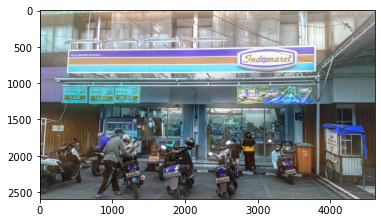

In [13]:
ocr_with_tesseract(img_path=img_path, east_model=east_model, min_confidence=min_confidence, width=width, height=height, tesseract_config = tesseract_config)

[INFO] text detection took 0.162431 seconds
Perguru urikulum JINDONESIF BAHASA ideas Kuliah Tinggi” Mata Nanas Gn Herman | 5. Wanib AR. PENULIS “Sayamal | i. 1 n Malabar
[INFO] OCR with tesseract took 2.2301368713378906 seconds


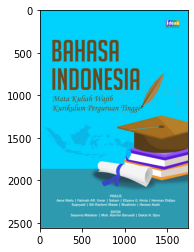

In [26]:
img_path = 'dataset/buku_indo.jpg'
ocr_with_tesseract(img_path=img_path, east_model=east_model, min_confidence=min_confidence, width=width, height=height, tesseract_config = tesseract_config)

# OCR per Character with TFModel

only do character recognition and combine it into one word. We need EAST to extract per word

In [7]:
from src.model import OCRModel
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import tensorflow as tf

make edged image

In [162]:
def ocr(text_detection_boxes, img_path, model, model_height_inp, model_width_inp, num_channel):
	start = time.time()
	# load the input image from disk, convert it to grayscale, and blur
	# it to reduce noise
	img = cv2.imread(img_path)
	#result of text detection
	(startX, startY, endX, endY) = text_detection_boxes
	cropped_image =  img[startY:endY, startX:endX]
	gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	# perform edge detection, find contours in the edge map, and sort the
	# resulting contours from left-to-right
	edged = cv2.Canny(blurred, 30, 150)
	cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sort_contours(cnts, method="left-to-right")[0]
	# initialize the list of contour bounding boxes and associated
	# characters that we'll be OCR'ing
	chars = []
	# loop over the contours
	for c in cnts:
		# compute the bounding box of the contour
		(x, y, w, h) = cv2.boundingRect(c)
		# filter out bounding boxes, ensuring they are neither too small
		# nor too large
		if (w >= 5 and w <= 30) and (h >= 15 and h <= 40):
			# extract the character and threshold it to make the character
			# appear as *white* (foreground) on a *black* background, then
			# grab the width and height of the thresholded image
			roi = gray[y:y + h, x:x + w]
			thresh = cv2.threshold(roi, 0, 255,
				cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
			(tH, tW) = thresh.shape
			# if the width is greater than the height, resize along the
			# width dimension
			if tW > tH:
				thresh = imutils.resize(thresh, width=model_width_inp)
			# otherwise, resize along the height
			else:
				thresh = imutils.resize(thresh, height=model_height_inp)
			# re-grab the image dimensions (now that its been resized)
			# and then determine how much we need to pad the width and
			# height such that our image will be 32x32
			(tH, tW) = thresh.shape
			dX = int(max(0, 32 - tW) / 2.0)
			dY = int(max(0, 32 - tH) / 2.0)
			# pad the image and force 32x32 dimensions
			padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
				left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
				value=(0, 0, 0))
			#need to adjust with the model input shape
			#28*28 is the model input shape
			padded = cv2.resize(padded, (model_width_inp, model_height_inp))
			# prepare the padded image for classification via our
			# handwriting OCR model
			padded = padded.astype("float32") / 255.0
			padded = np.expand_dims(padded, axis=-1)
			# update our list of characters that will be OCR'd
			chars.append((padded, (x, y, w, h)))
	if len(chars)==0:
		raise Exception("Sorry no chars detected")
	# extract the bounding box locations and padded characters
	boxes = [b[1] for b in chars]
	chars = np.array([c[0] for c in chars], dtype="float32")
	#OCR the characters using our handwriting recognition model
	preds = model.model.predict(tf.image.grayscale_to_rgb(tf.convert_to_tensor(chars)))
	# define the list of label names
	labelNames = "0123456789"
	labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
	labelNames = [l for l in labelNames]
	# loop over the predictions and bounding box locations together
	text = ""
	for (pred, (x, y, w, h)) in zip(preds, boxes):
		# find the index of the label with the largest corresponding
		# probability, then extract the probability and label
		i = np.argmax(pred)
		prob = pred[i]
		label = labelNames[i]
		#add the label
		text+=label
	end = time.time()
	print(f"[INFO] time for OCR {end - start}")
	return text, chars

# Pipeline to do all OCR steps

In [163]:
img_path = 'dataset/test_ocr.png'
east_path = 'models/frozen_east_text_detection.pb'
ocr_model_path = 'models/mobilenet_noaugment/cp.ckpt'
model = OCRModel()
model.load(model_type='mobilenet', model_path=ocr_model_path)
east_model = cv2.dnn.readNet(east_path)
min_confidence = 0.5
width = 320#need to be multiple of 32
height = 320#need to be multiple of 32
model_height_inp = 32
model_width_inp = 32
num_channel = 3

[INFO] text detection took 0.285924 seconds


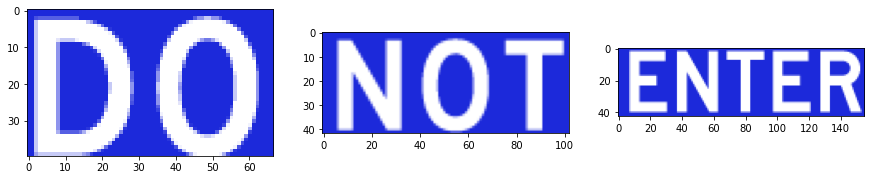

In [164]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
img_path = 'dataset/test_ocr.png'
img = cv2.imread(img_path)
text_detection_boxes = text_detection(img_path, east_model, min_confidence, width, height)
fig, axs = plt.subplots(nrows=1, ncols=len(text_detection_boxes), figsize=(15,10))
for i,(startX, startY, endX, endY) in enumerate(text_detection_boxes):
	if len(text_detection_boxes)==1:
		axs.imshow(img[startY:endY, startX:endX,:])
	else:
		axs[i].imshow(img[startY:endY, startX:endX,:])

In [167]:
for box in text_detection_boxes[:1]:
    text,chars = ocr(box, img_path, model, model_height_inp, model_width_inp, num_channel)
    print(text)

1/1 [==============================] - 0s 19ms/step
[INFO] time for OCR 0.06533527374267578
OOOO


In [168]:
len(chars)

4

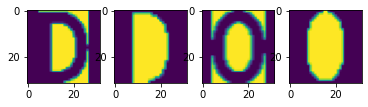

In [169]:
fig, axs = plt.subplots(1,len(chars))
for i in range(len(chars)):
    axs[i].imshow(chars[i])

In [13]:
def predict_image(img):
  image = cv2.imread(img)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(blurred, 30, 150)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]
  chars = []


  #cv2_imshow(edged)

  for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
      # extract the character and threshold it to make the character
      # appear as *white* (foreground) on a *black* background, then
      # grab the width and height of the thresholded image
      roi = gray[y:y + h, x:x + w]
      thresh = cv2.threshold(roi, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      (tH, tW) = thresh.shape
      # if the width is greater than the height, resize along the
      # width dimension
      if tW > tH:
        thresh = imutils.resize(thresh, width=32)
      # otherwise, resize along the height
      else:
        thresh = imutils.resize(thresh, height=32)
      (tH, tW) = thresh.shape
      dX = int(max(0, 32 - tW) / 2.0)
      dY = int(max(0, 32 - tH) / 2.0)
      # pad the image and force 32x32 dimensions
      padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0))
      padded = cv2.resize(padded, (32, 32))
      padded = padded.astype("float32")
      padded = np.expand_dims(padded, axis=-1)
      chars.append((padded, (x, y, w, h)))
      #cv2_imshow(padded)

    #print("Padded: -")
    #cv2_imshow(padded)

  """
  padded = cv2.copyMakeBorder(blurred, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
  padded = cv2.resize(padded, (32, 32))
  """
  #final_image=np.expand_dims(padded,axis=2)
  #print(chars)
  boxes = [b[1] for b in chars]
  #cv2_imshow(chars)
  chars = np.array([c[0] for c in chars], dtype="float32")
  # OCR the characters using our handwriting recognition model
#   preds = model.predict(chars)
#   # define the list of label names
#   labelNames = "0123456789"
#   labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#   labelNames = [l for l in labelNames]
#   output=""
#   for (pred, (x, y, w, h)) in zip(preds, boxes):
#     i = np.argmax(pred)
#     prob = pred[i]
#     label = labelNames[i]
#     output+=label
  
  return chars

In [171]:
img_path = 'dataset/test_ocr.png'
text_detection_boxes = text_detection(img_path, east_model, min_confidence, width, height)
img = cv2.imread(img_path)
(startX, startY, endX, endY) = text_detection_boxes[0]
cropped_image =  img[startY:endY, startX:endX]
gray = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)

[INFO] text detection took 0.116098 seconds


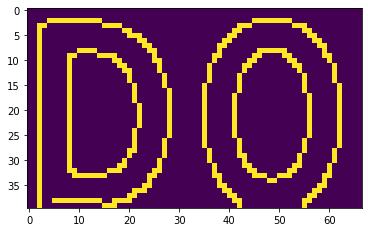

In [172]:
plt.imshow(edged)

In [173]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

In [174]:
gray.shape, len(cnts)

((40, 67), 4)

2 2 27 38


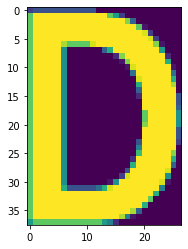

In [176]:
i=0
(x, y, w, h) = cv2.boundingRect(cnts[i])
print(x, y, w, h)
plt.imshow(gray[y:y + h, x:x + w])

8 8 15 26


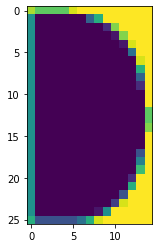

In [177]:
i=1
(x, y, w, h) = cv2.boundingRect(cnts[i])
print(x, y, w, h)
plt.imshow(gray[y:y + h, x:x + w])

Pada gambar text_ocr.png
untuk yang text detection 1
- img shape : 40,67
- edge yang bagus punya w,h : (27,38), (28,38)
untuk text detection 2
- img shape : 42,102
- edge yang bagus punya w,h : (27,39), (28,38), (25,39)
untuk text detection 3
- img shape : 43,155
- edge yang bagus punya w,h : (24,39), (24,39), (27,39)

Pada gambar text_ocr2.png
untuk yang text detection 1
- img shape : 41,109
- edge yang bagus punya w,h : (23,33), (13,22), (19,19), (5,26)
untuk yang text detection 2
- img shape : 36,118
- edge yang bagus punya w,h : (16,28), (13,19), (10,19), (14,21), (17,18), (5,16)